In [1]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseTransformer, self_columns, reset_columns

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

import warnings

In [2]:
df_train = pd.read_csv('data/train.csv')
train, test = tml.make_test(df_train, test_size=0.25, random_state=43, strat_feat=['Pclass', 'Sex'])
kfolds = KFold(n_splits=10, random_state=235, shuffle=True)
train_cols = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24665,24665,0,3,"Jones, Rhett",male,44.0,0,0,25604,25.17,NaN,S
67933,67933,0,3,"Twomey, Paul",male,27.0,0,0,478284,11.53,NaN,S
41148,41148,0,3,"Brady, Amy",female,7.0,1,1,10375,80.13,NaN,S
49460,49460,0,3,"Shealy, William",male,37.0,0,0,C 15695,7.69,NaN,S
69515,69515,0,1,"Kolb, Willie",male,65.0,1,1,23480,77.39,C6991,C


In [3]:
class new_feats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['fam_size'] = X_tr['Parch'] + X_tr['SibSp']
        X_tr['Emb_Sex'] = X_tr['Sex'] + '_' + X_tr['Embarked']
        return X_tr

In [4]:
models = [('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=8, )),
          ('logit', LogisticRegression(C=1, max_iter=2000)),
          ('xgb', xgb.XGBClassifier(n_estimators=2000, n_jobs=-1, reg_alpha=0.3, learning_rate=0.05,
                                    reg_lambda=1, subsample=0.7, max_depth=4, 
                                    random_state=324,objective='binary:logistic',use_label_encoder=False, eval_metric='logloss')), 
          ('lgb', lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.05, reg_alpha=0.3, reg_lambda=1, subsample=0.7, n_jobs=-1))]

In [5]:
oof_res = {}

for model in models:
    print(model[0])
    num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', tml.DfImputer(strategy='median'))])

    cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                         ('imp', tml.DfImputer(strategy='most_frequent')), 
                         ('dum', tml.Dummify(drop_first=True))])

    proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                     ('cat', cat_pipe)])
    
    full_pipe = Pipeline([('new', new_feats()), ('proc', proc_pipe), model])
    
    if (model[0] == 'tree') or (model[0 == 'logit']):
        oof = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True)
    else:
        oof = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True, early_stopping=100, eval_metric='logloss')
        
    oof_res[model[0]] = oof
    
    tml.eval_classification(train, train.Survived, oof, plot=0, proba=True)

tree
Accuracy score: 	0.768
AUC ROC: 		0.8361
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     42902
           1       0.71      0.78      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000

logit
Accuracy score: 	0.7662
AUC ROC: 		0.8267
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     42902
           1       0.71      0.76      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.76      0.77      0.76     75000
weighted avg       0.77      0.77      0.77     75000

xgb
Accuracy score: 	0.7697
AUC ROC: 		0.8389
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     42902
           1       0.73      0.73      0.73     32098

    accuracy                           0.7

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


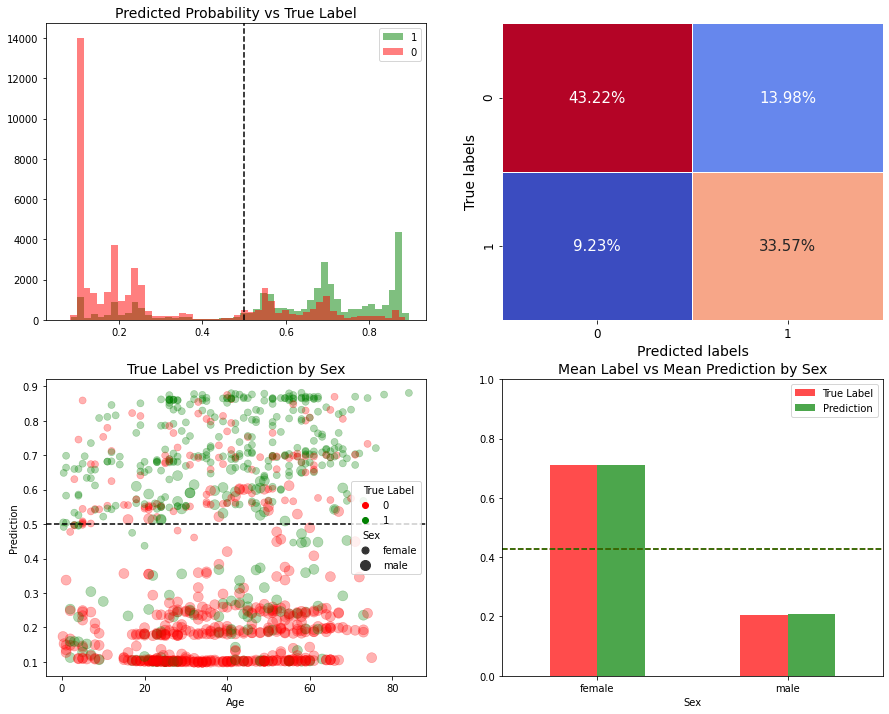

Accuracy score: 	0.768
AUC ROC: 		0.8361
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     42902
           1       0.71      0.78      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



In [6]:
tml.eval_classification(train, train.Survived, oof_res['tree'], plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


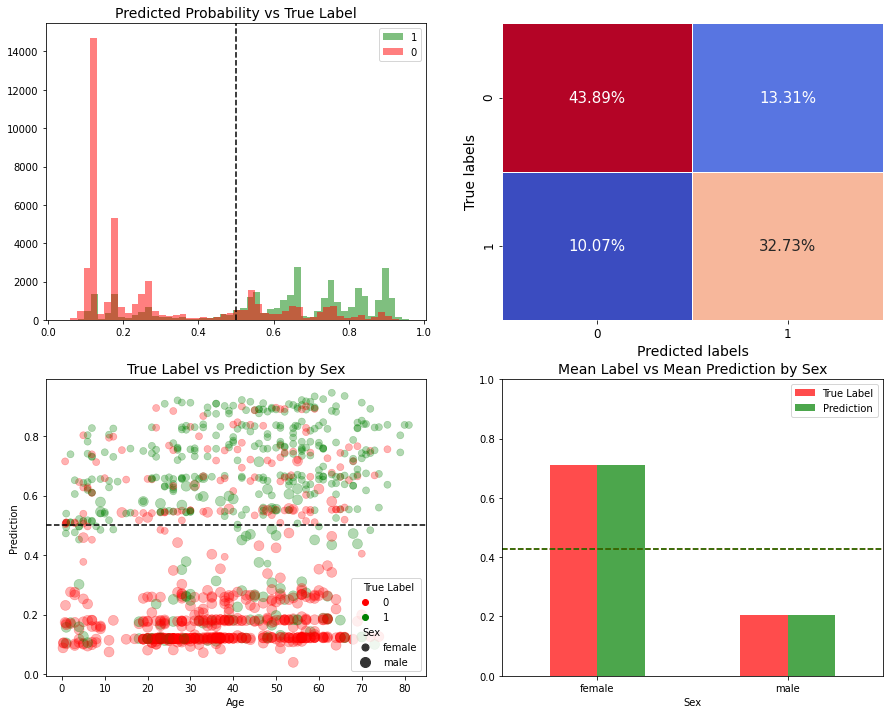

Accuracy score: 	0.7662
AUC ROC: 		0.8267
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     42902
           1       0.71      0.76      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.76      0.77      0.76     75000
weighted avg       0.77      0.77      0.77     75000



In [7]:
tml.eval_classification(train, train.Survived, oof_res['logit'], plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


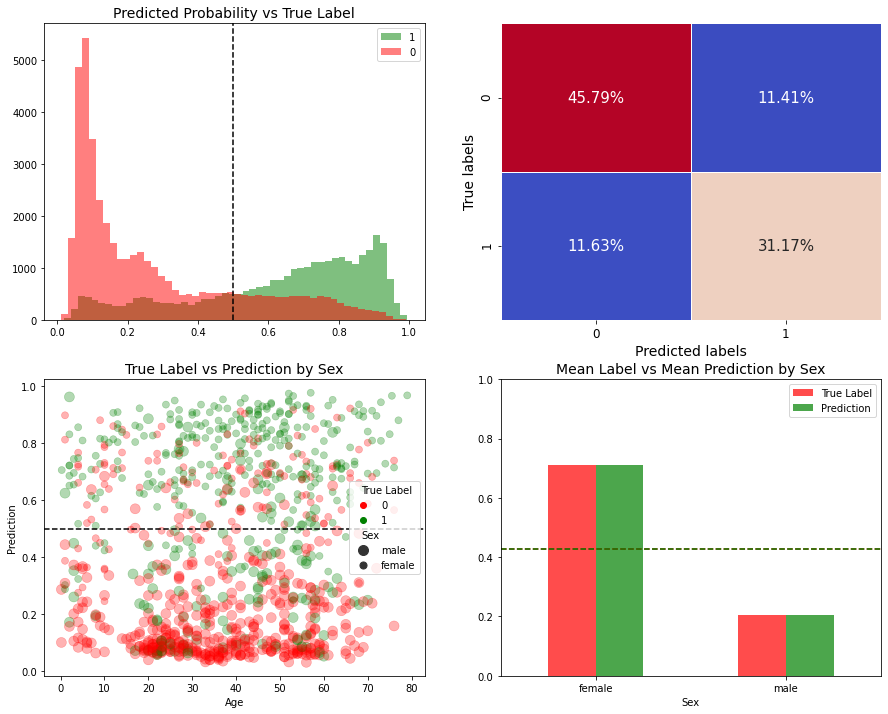

Accuracy score: 	0.7697
AUC ROC: 		0.8389
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     42902
           1       0.73      0.73      0.73     32098

    accuracy                           0.77     75000
   macro avg       0.76      0.76      0.76     75000
weighted avg       0.77      0.77      0.77     75000



In [8]:
tml.eval_classification(train, train.Survived, oof_res['xgb'], plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


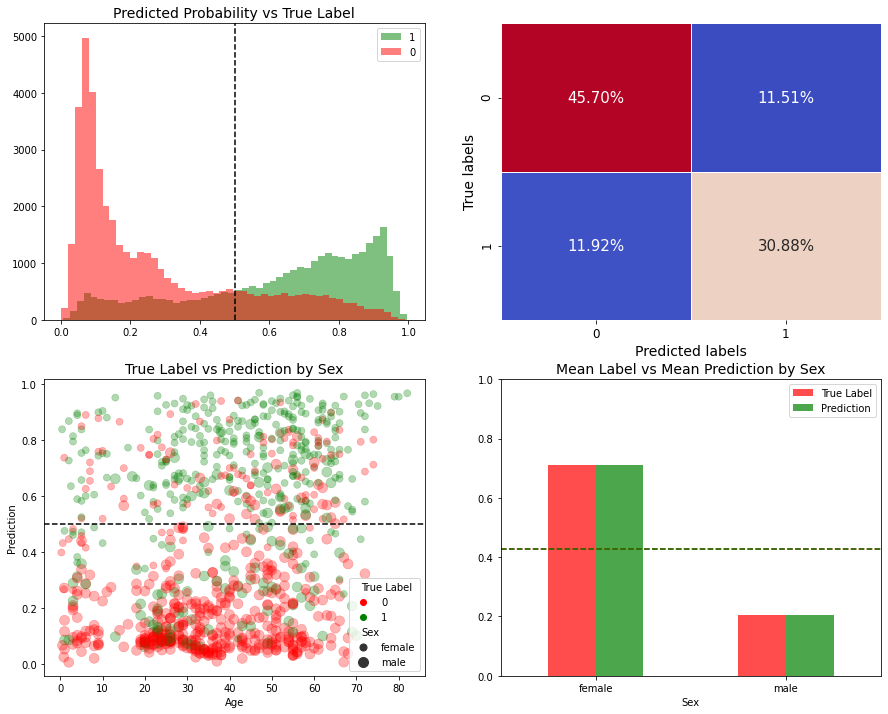

Accuracy score: 	0.7657
AUC ROC: 		0.834
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     42902
           1       0.73      0.72      0.72     32098

    accuracy                           0.77     75000
   macro avg       0.76      0.76      0.76     75000
weighted avg       0.77      0.77      0.77     75000



In [9]:
tml.eval_classification(train, train.Survived, oof_res['lgb'], plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')